In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

import timeit

from emu_mps import (
    MPS,
    MPSConfig,
    MPSBackend,
    BitStrings,
    Fidelity,
    QubitDensity,
)
import logging
from pulser.noise_model import NoiseModel
#import qoolbox as qb
from dataclasses import replace
from pulser import Pulse, Register, Sequence
from pulser.channels import Rydberg,DMM
from pulser.devices import Device
from pulser.waveforms import InterpolatedWaveform
import os
from pulser import QPUBackend
from pulser.backend import EmulatorConfig
from pulser.register.special_layouts import TriangularLatticeLayout
from emu_sv import SVBackend,SVConfig
from emu_sv.hamiltonian import RydbergHamiltonian

from typing import Any
import sys

import json
import pulser

from typing import Tuple

import networkx as nx
import numpy as np
from pulser.devices._device_datacls import BaseDevice
from scipy.spatial.distance import euclidean
import pyomo.environ as pyo

def get_interactions(
    pos: np.ndarray, graph: nx.Graph, device: BaseDevice
) -> tuple[list[float], list[float]]:
    """Calculate the interaction strengths for connected and disconnected nodes.

    Args:
        pos (np.ndarray): The position of the nodes.
        graph (nx.Graph): The associated graph.
        device (BaseDevice): Device used to calculate interaction coeff.

    Returns:
        tuple[list[Any], list[Any]]: Connected interactions, Disconnected interactions
    """

    def calculate_edge_interaction(edge: tuple[int, int]) -> float:
        pos_a, pos_b = pos[edge[0]], pos[edge[1]]
        return float(device.interaction_coeff / (euclidean(pos_a, pos_b) ** 6))

    connected = [calculate_edge_interaction(edge) for edge in graph.edges()]
    disconnected = [calculate_edge_interaction(edge) for edge in nx.complement(graph).edges()]

    return connected, disconnected


def interaction_bounds(pos: np.ndarray, graph: nx.Graph, device: BaseDevice) -> Tuple[float, float]:
    """Calculates U_min and U_max given the positions. It uses the edges of the
    graph. U_min corresponds to minimal energy of two nodes connected in the
    graph. U_max corresponds to maximal energy of two nodes NOT connected in
    the graph."""
    connected, disconnected = get_interactions(pos, graph, device)  # type: ignore[misc]
    if len(connected) == 0:
        u_min = 0
    else:
        u_min = np.min(connected)
    if len(disconnected) == 0:
        u_max = np.inf
    else:
        u_max = np.max(disconnected)
    return u_min, u_max

def solve_MIS(my_graph: nx.Graph) -> Any:
    """
    Uses pyomo to solve the maximum independent set problem on the provided
    graph, returning the vertices forming the largest set of which none
    are directly connected to one another.

    If the graph has the attribute "is-weighted", then a
    maximum weighted independent set problem is solved using the "value" attribute
    as an edge weight.
    """
    # if weights is empty, fill with ones
    if my_graph.graph.get("is-weighted", False):
        raise ValueError("you should use the MWIS function for weighted graph")
    else:
        weights = {node: 1 for node in my_graph.nodes()}
        my_model = pyo.ConcreteModel("MIS")  # model

    my_model.V = pyo.Set(initialize=list(my_graph.nodes()))  # set of vertices
    my_model.E = pyo.Set(initialize=list(my_graph.edges()))  # set of edges
    my_model.x = pyo.Var(
        my_model.V, domain=pyo.Binary, initialize=True
    )  # holds 1 iff node u is in the IS; 0 otherwise

    # Constraints --> two nodes u and v cannot be in the IS if they are connected
    def const1(self, u: Any, v: Any) -> Any:  # type: ignore
        return my_model.x[u] + my_model.x[v] <= 1

    my_model.const1 = pyo.Constraint(my_model.E, rule=const1)

    # Objective Funtion --> maximize the size of the IS
    def obj_rule(self) -> Any:  # type: ignore
        return sum(my_model.x[u] * weights[u] for u in my_model.V)

    my_model.obj = pyo.Objective(rule=obj_rule, sense=pyo.maximize)

    # solving model
    start = timeit.default_timer()  # runtime's start-point
    _ = pyo.SolverFactory("cplex").solve(my_model)
    stop = timeit.default_timer()  # runtime's end-point

    # geting the results
    set_M = []
    for u in list(my_graph.nodes()):
        if pyo.value(my_model.x[u]) >= 1 - 10e-2:
            set_M.append(u)

    # returning the solution
    return set_M, stop - start



global_channel = Rydberg.Global(
            max_abs_detuning= 10 * 200 * np.pi,
            max_amp= 2 * 2* np.pi,  
            clock_period=4,
            min_duration=16,
            mod_bandwidth=10, 
        )


dmm = DMM(
    clock_period=4,
    min_duration=16,
    max_duration=2**26,
    mod_bandwidth=8,
    bottom_detuning = -2 * np.pi * 20000, # detuning between 0 and -20 MHz
    total_bottom_detuning= -2 * np.pi * 2000000,  # total detuning
)

device = Device(
    name=f"device",
    dimensions=2,
    rydberg_level=60, 
    min_atom_distance=5,
    max_atom_num=100, 
    max_radial_distance=100,
    max_sequence_duration=50000,
    channel_objects= [global_channel],
    dmm_objects=[dmm],
    pre_calibrated_layouts=(),  # add Square and Triangular?
)

In [6]:
def calc_bounds(reg, graph, device):
    # Since graph is mandatory, no need to check for None
    _, disconnected = get_interactions(reg._coords, graph, device)
    u_min, u_max = interaction_bounds(reg._coords, graph, device)
    max_amp_device = device.channels["rydberg_global"].max_amp or np.inf
    maximum_amplitude = min(max_amp_device, u_max + 0.8 * (u_min - u_max))

    # Safely access graph attributes since graph is mandatory
    d_min = min(dict(graph.degree).values())
    d_max = max(dict(graph.degree).values())
    det_max_theory = (d_min / (d_min + 1)) * u_min
    det_min_theory = sum(sorted(disconnected)[-d_max:])
    det_final_theory = max([det_max_theory, det_min_theory])
    det_max_device = device.channels["rydberg_global"].max_abs_detuning or np.inf
    final_detuning = min(det_final_theory, det_max_device)

    return maximum_amplitude,final_detuning


reg_layout = TriangularLatticeLayout(200,spacing=5)
coords=reg_layout.coords
coords_dist=np.array([np.linalg.norm(x) for x in coords])

idx=np.argsort(coords_dist)

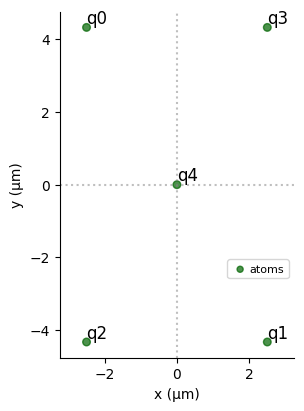

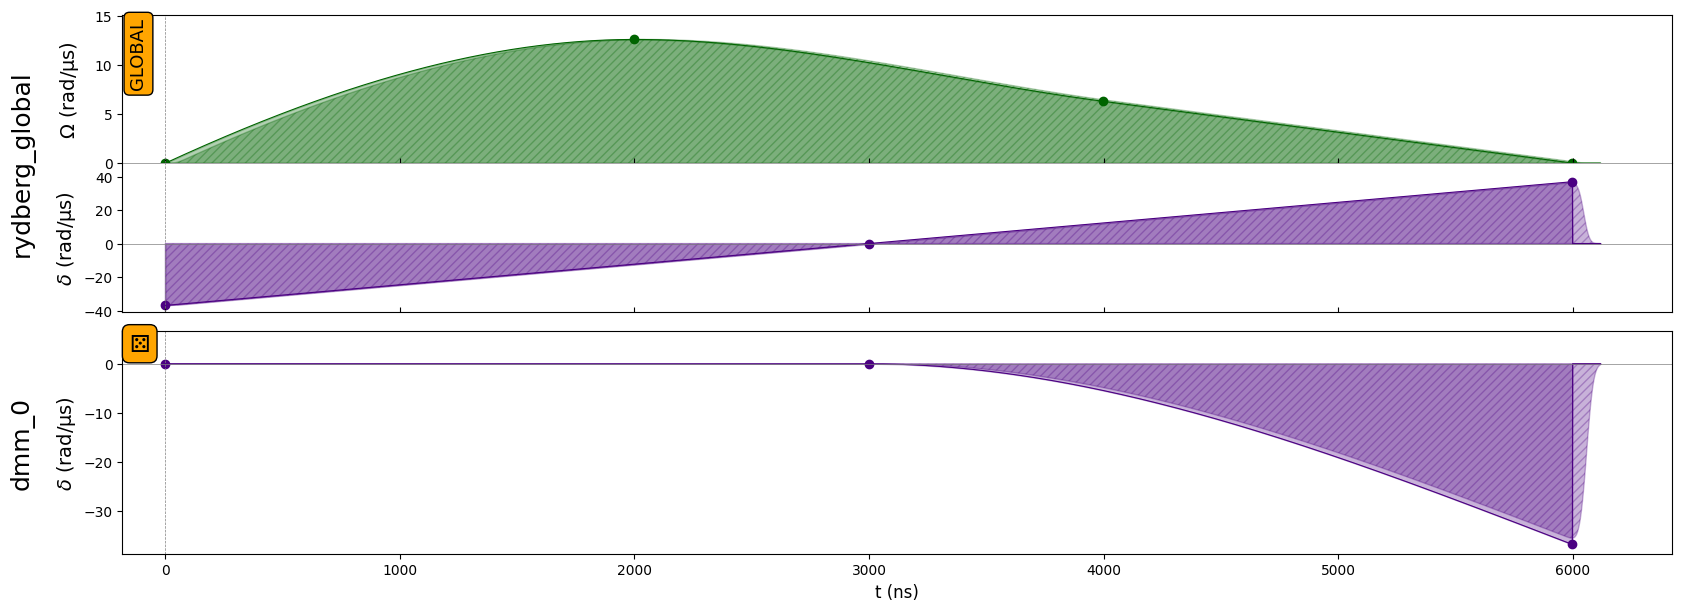

step = 1/600, RSS = 8.599 MB, Δt = 0.005 s
step = 2/600, RSS = 8.599 MB, Δt = 0.006 s
step = 3/600, RSS = 8.599 MB, Δt = 0.008 s
step = 4/600, RSS = 8.599 MB, Δt = 0.009 s
step = 5/600, RSS = 8.599 MB, Δt = 0.009 s
step = 6/600, RSS = 8.599 MB, Δt = 0.009 s
step = 7/600, RSS = 8.599 MB, Δt = 0.008 s
step = 8/600, RSS = 8.599 MB, Δt = 0.008 s
step = 9/600, RSS = 8.599 MB, Δt = 0.007 s
step = 10/600, RSS = 8.599 MB, Δt = 0.008 s
step = 11/600, RSS = 8.599 MB, Δt = 0.009 s
step = 12/600, RSS = 8.599 MB, Δt = 0.009 s
step = 13/600, RSS = 8.599 MB, Δt = 0.009 s
step = 14/600, RSS = 8.599 MB, Δt = 0.009 s
step = 15/600, RSS = 8.599 MB, Δt = 0.009 s
step = 16/600, RSS = 8.599 MB, Δt = 0.009 s
step = 17/600, RSS = 8.599 MB, Δt = 0.009 s
step = 18/600, RSS = 8.599 MB, Δt = 0.009 s
step = 19/600, RSS = 8.599 MB, Δt = 0.009 s
step = 20/600, RSS = 8.599 MB, Δt = 0.009 s
step = 21/600, RSS = 8.599 MB, Δt = 0.009 s
step = 22/600, RSS = 8.599 MB, Δt = 0.009 s
step = 23/600, RSS = 8.599 MB, Δt = 0.009

In [ ]:
N=5
density=1.0
sim_params={"N":N,
            "N_samples":2**N,
            "density": density}

sim_params["L"]=int(np.ceil(sim_params["N"]/sim_params["density"]))
sim_params["idx_avail"]=idx[:sim_params["L"]]
sim_params["idx_list"] = np.random.choice(sim_params["idx_avail"],sim_params["N"],replace=False).tolist()
sim_params['graphs']=[]
sim_params['mis_sol']=[]

pos={}
for i,x in enumerate(coords[sim_params["idx_list"]]):
    pos[i]=tuple(x)
graph=nx.random_geometric_graph(n=len(pos),pos=pos,radius=6)
sim_params['graphs'].append(graph)
sim_params['mis_sol'].append(solve_MIS(graph))
node_weights=node_weights = {node: 1 for node in graph.nodes()}



reg=reg_layout.define_register(*sim_params['idx_list'])
max_amplitude,max_detuning=calc_bounds(reg, graph, device)
sim_params['amplitude']=[1e-9,max_amplitude,1e-9]
sim_params['detuning']=[-max_detuning,0,max_detuning]
sim_params['dmm']=[0,0,-max_detuning]
sim_params['duration']=6000
sim_params["Rb"]=device.rydberg_blockade_radius(max(sim_params['amplitude']))

sim_params["reg"]=reg
reg.draw()

sequence = Sequence(reg, device)
duration = sim_params['duration']
omega_list= sim_params['amplitude']
delta_list= sim_params['detuning']
delta_list_dmm= sim_params['dmm']
amp = InterpolatedWaveform(duration,omega_list)
det = InterpolatedWaveform(duration,delta_list)
sequence.declare_channel("rydberg_global", "rydberg_global")
sequence.add(Pulse(amp, det, 0), "rydberg_global")

norm_node_weights = [(1 - (x / max(node_weights.values()))) for x in node_weights.values()]
detuning_map = reg_layout.define_detuning_map({i: x for i,x in enumerate(norm_node_weights)})
sequence.config_detuning_map(detuning_map, 'dmm_0')
dmm_wave = InterpolatedWaveform(duration,delta_list_dmm)
sequence.add_dmm_detuning(dmm_wave, 'dmm_0')

sequence.draw()

sim = SVBackend()
dt = 10
final_time = (sequence.get_duration() // dt * dt)  
eval_times = list(np.arange(0,final_time+dt,100*dt))
bitstrings = BitStrings(evaluation_times=eval_times, num_shots=sim_params["N_samples"])
sim_config = SVConfig(
            gpu=True,
            dt = dt,
            observables = [bitstrings], 
            #log_level = logging.WARN,
            )
result = sim.run(sequence, sim_config)
counts=result['bitstrings']